# Using the virtual dot array

In this example we use the virtual dot array to show how to perofrm measurements and analysis using QTT. For a real device the measurements and analysis will go exactly the same (although you will have more noise and the scans will have more distortions).

In [2]:
%matplotlib inline

import tempfile

import qcodes
from qcodes.plots.pyqtgraph import QtPlot
from qcodes.plots.qcmatplotlib import MatPlot
from qcodes.data.data_set import DataSet

import qtt
from qtt import createParameterWidget
from qtt.algorithms.gatesweep import analyseGateSweep
from qtt.measurements.scans import scanjob_t
from qtt.instrument_drivers.virtual_gates import virtual_gates, create_virtual_matrix_dict

from qtt import save_state, load_state
import qtt.measurements.videomode

import qtt.simulation.virtual_dot_array
import numpy as np
np.set_printoptions(precision=2, suppress=True)
datadir = tempfile.mkdtemp(prefix='qtt_example')
DataSet.default_io = qcodes.data.io.DiskIO(datadir)

## Create a virtual model for testing

 The model resembles the spin-qubit dot setup. The hardware consists of a virtual
 keithley, IVVI racks and a virtual gates object

In [3]:
nr_dots = 3
station = qtt.simulation.virtual_dot_array.initialize(reinit=True, nr_dots=nr_dots, maxelectrons=2)
print(station.components.keys())

initialize: create virtual dot system
initialized virtual dot system (3 dots)
dict_keys(['gates', 'keithley1', 'keithley3', 'keithley4', 'ivvi1', 'ivvi2', 'vawg', 'sdigitizer', 'dotmodel'])


In [4]:
keithley1 = station.keithley1
keithley3 = station.keithley3

gates = station.gates

## Simple 1D scan loop

scan1D: 0/625: time 0.0
scan1D: 424/625: time 1.5
DataSet:
   location = '2020-08-31/15-49-00_qtt_scan1D'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | amplitude  | amplitude    | (625,)
   Setpoint | B3         | B3           | (625,)


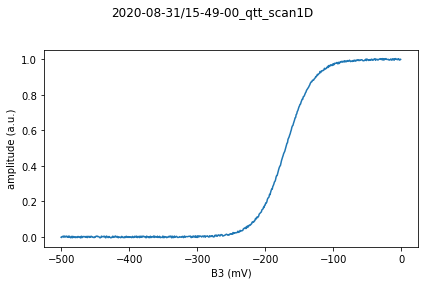

In [5]:
param_left=station.model.bottomgates[0]
param_right=station.model.bottomgates[-1]
scanjob = scanjob_t({'sweepdata': dict({'param': param_right, 'start': -500, 'end': 0, 'step': .8, 'wait_time': 3e-3}), 'minstrument': ['keithley3.amplitude']})
data1d = qtt.measurements.scans.scan1D(station, scanjob, location=None, verbose=1)

print(data1d)

_ = MatPlot(data1d.default_parameter_array())

## Fit 1D pinch-off scan:

analyseGateSweep: pinch-off point -187.200, value 0.297


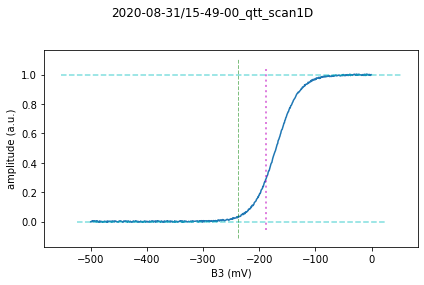

In [6]:
adata = analyseGateSweep(data1d, fig=100)

## Make a 2D scan

scan2D: 0/80: time 00:00:00 (~00:00:00 remaining): setting B0 to -500.000
scan2D: 74/80: time 00:00:01 (~00:00:00 remaining): setting B0 to -130.000


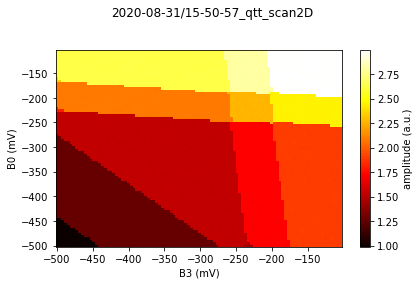

In [7]:
start = -500
scanjob = scanjob_t({'sweepdata': dict({'param': param_right, 'start': start, 'end': start + 400, 'step': 4., 'wait_time': 0.}), 'minstrument': ['keithley1.amplitude']})
scanjob['stepdata'] = dict({'param': param_left, 'start': start, 'end': start + 400, 'step': 5.})
data2d = qtt.measurements.scans.scan2D(station, scanjob)

_ = MatPlot(data2d.default_parameter_array())

In [8]:
gv={'B0': -300.000,'B1': 0.145,'B2': -0.357,'B3': -300.000,'D0': 0.085,'O1': 0.222,'O2': -0.403,'O3': 0.117,'O4': -0.275,'O5': -0.163,'P1': 30.,'P2': -40,'P3': -0.072,'SD1a': 0.254,'SD1b': -0.442,'SD1c': 0.252,'bias_1': 0.337,'bias_2': -0.401}
gates.resetgates(gv, gv)

resetgates: setting gates to default values
  setting gate B0 to -300.0 [mV]
  setting gate B1 to 0.1 [mV]
  setting gate B2 to -0.4 [mV]
  setting gate B3 to -300.0 [mV]
  setting gate D0 to 0.1 [mV]
  setting gate O1 to 0.2 [mV]
  setting gate O2 to -0.4 [mV]
  setting gate O3 to 0.1 [mV]
  setting gate O4 to -0.3 [mV]
  setting gate O5 to -0.2 [mV]
  setting gate P1 to 30.0 [mV]
  setting gate P2 to -40.0 [mV]
  setting gate P3 to -0.1 [mV]
  setting gate SD1a to 0.3 [mV]
  setting gate SD1b to -0.4 [mV]
  setting gate SD1c to 0.3 [mV]
  setting gate bias_1 to 0.3 [mV]
  setting gate bias_2 to -0.4 [mV]


## Make virtual gates

Instread of scanning physical gates, we can also scan linear combinations of gates. We use the `virtual_gates` object to define linear combinations and make scans.

In [ ]:
gates.resetgates(gv, gv, 0)

c = np.array([[1,.56,.15],[.62,1,.593],[.14,.62,1.]])
crosscap_map = create_virtual_matrix_dict(['vP1', 'vP2', 'vP3'], ['P1', 'P2', 'P3'], c=c)
virts = virtual_gates(qtt.measurements.scans.instrumentName('vgates'), gates, crosscap_map)
virts.print_matrix()

In [ ]:
r=100
scanjob = scanjob_t({'sweepdata': dict({'param': virts.vP1, 'start': -r, 'end': r, 'step': 4.}), 'minstrument': ['keithley1.amplitude']})
scanjob['stepdata'] = dict({'param': virts.vP2, 'start': -50 - r, 'end': -50 +r, 'step': 2.})
data_virtual_gates = qtt.measurements.scans.scan2D(station, scanjob)

_ = MatPlot(data_virtual_gates.default_parameter_array())

In [9]:
data1d

DataSet:
   location = '2020-08-31/15-49-00_qtt_scan1D'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | amplitude  | amplitude    | (625,)
   Setpoint | B3         | B3           | (625,)

In [10]:
data2d

DataSet:
   location = '2020-08-31/15-50-57_qtt_scan2D'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | amplitude  | amplitude    | (80, 100)
   Setpoint | B3         | B3           | (80, 100)
   Setpoint | B0         | B0           | (80,)

In [11]:
plt.plot(data1d)

NameError: name 'plt' is not defined